In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [4]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
         break
print('Dataset is Loaded')

Dataset is Loaded


In [5]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [6]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [7]:
sp_df = pd.DataFrame()
sp_df['speech'] = paths
sp_df['emotion'] = labels
sp_df.head()

,speech,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [8]:
sp_df['emotion'].value_counts()

emotion
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

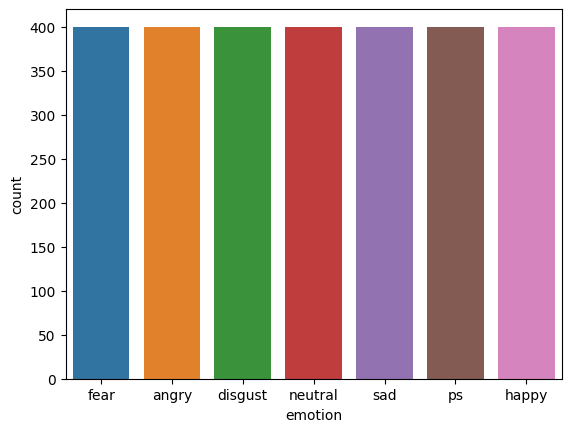

In [9]:
sns.countplot(x = sp_df['emotion'])

In [15]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(emotion, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()

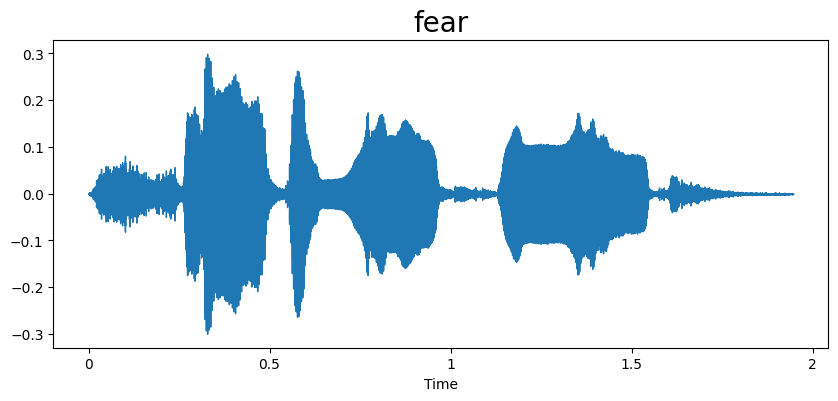

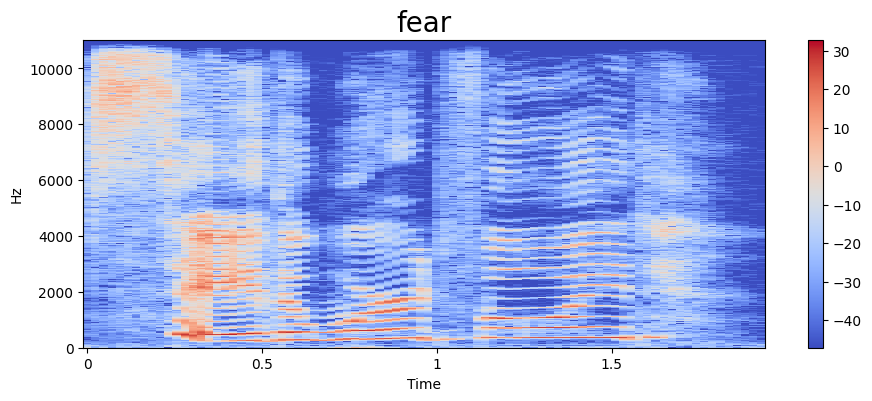

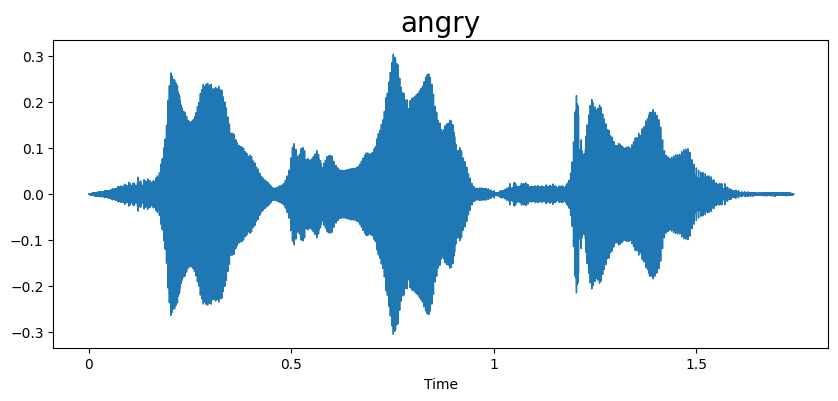

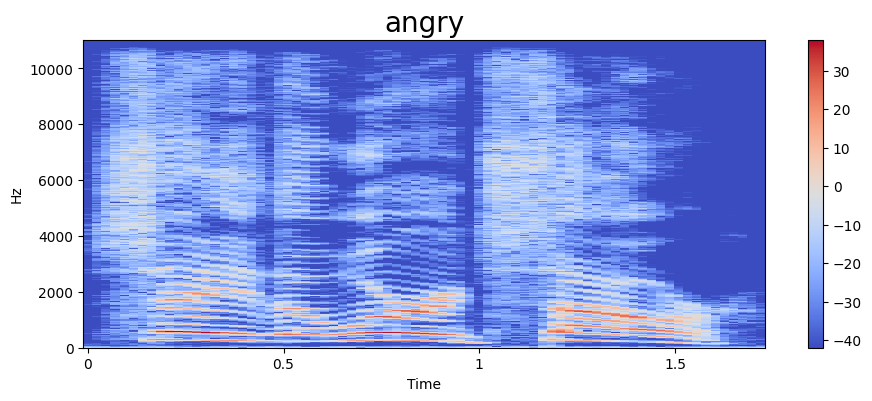

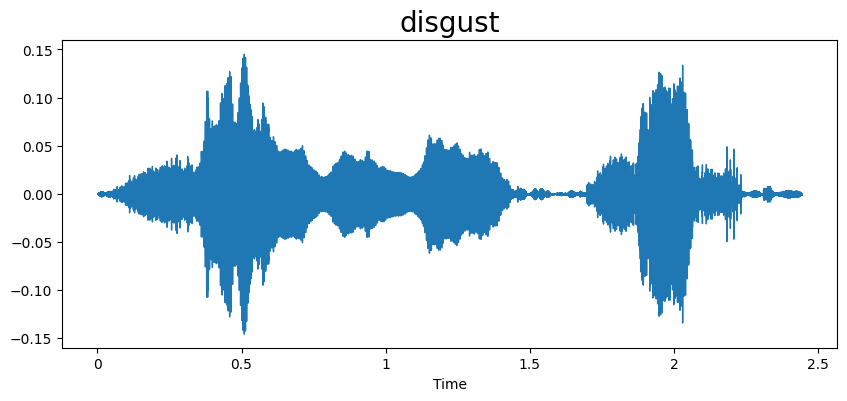

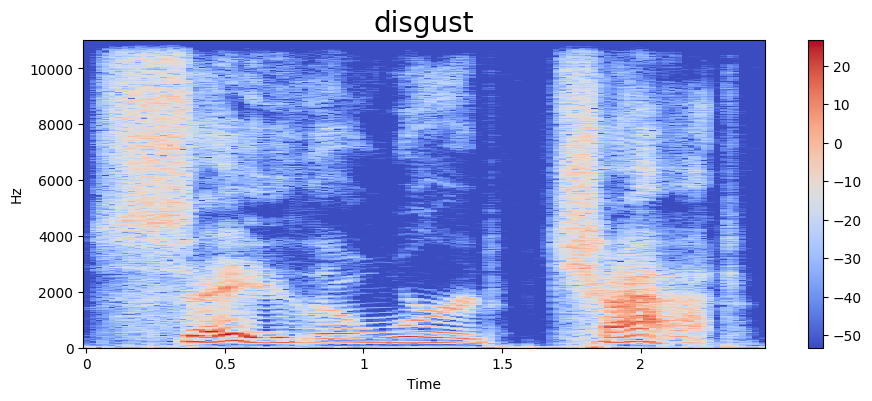

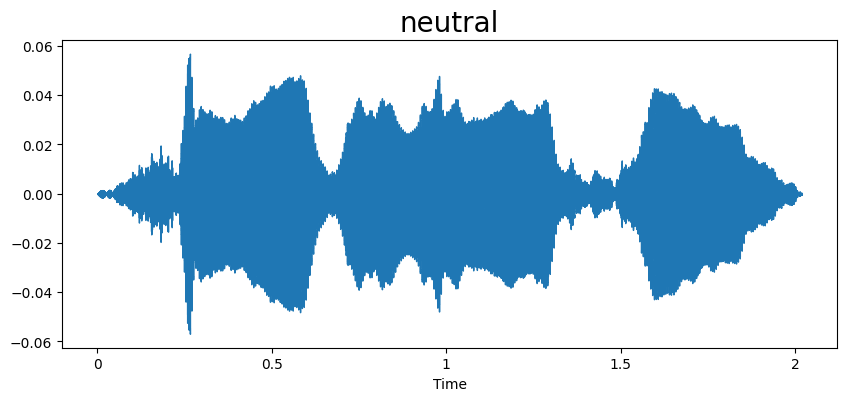

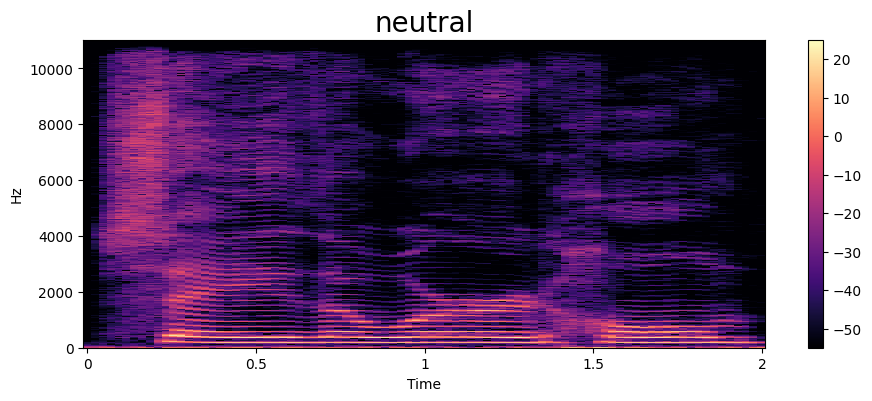

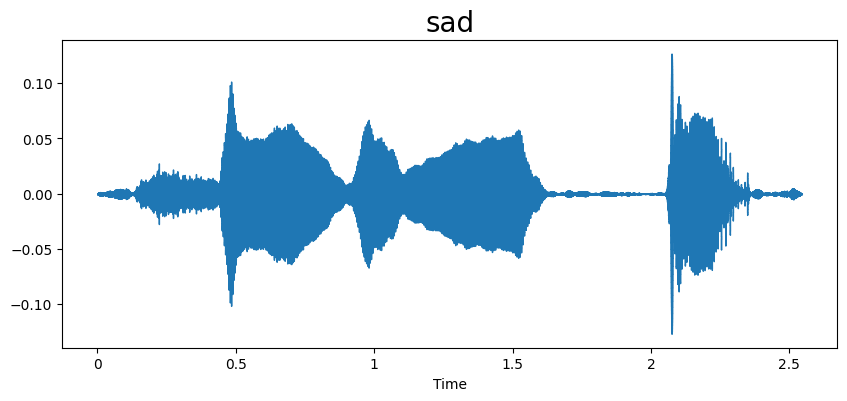

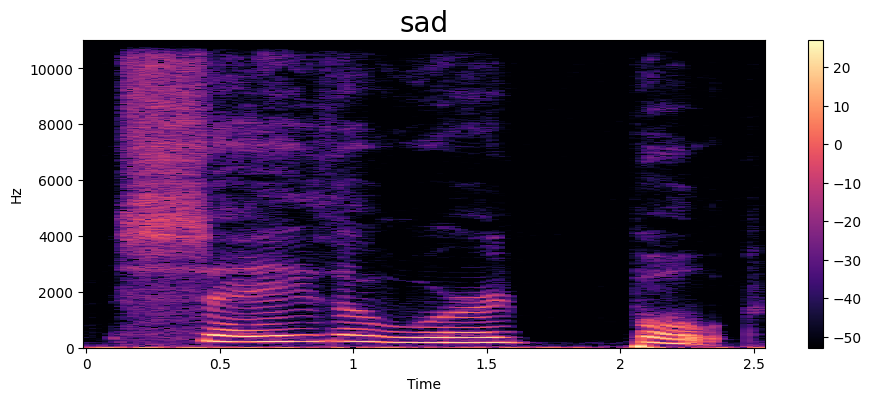

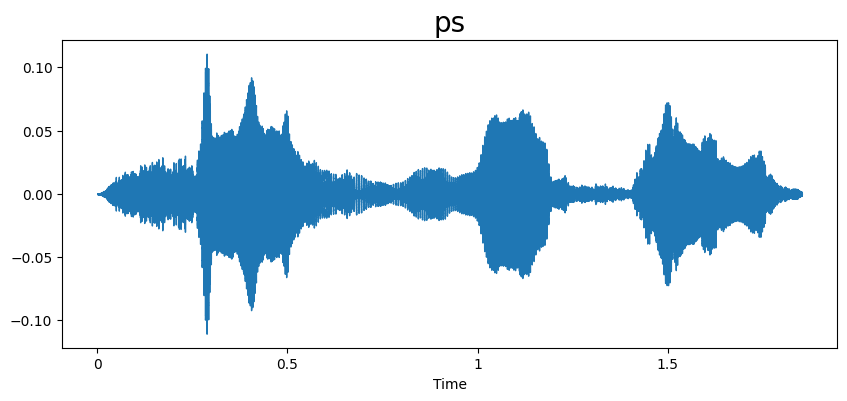

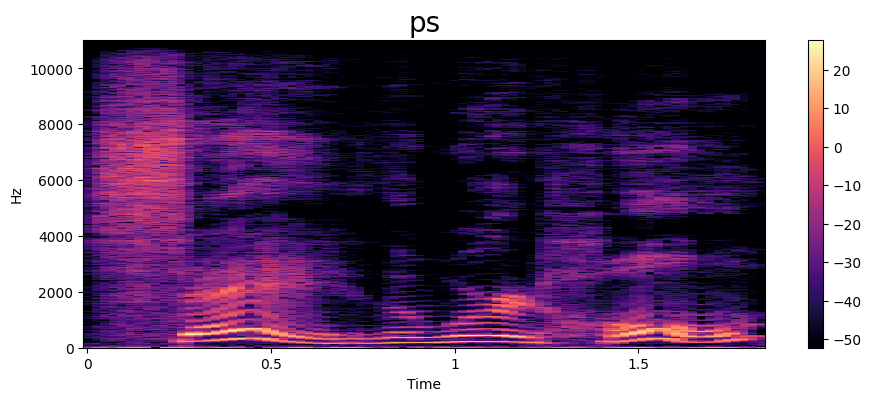

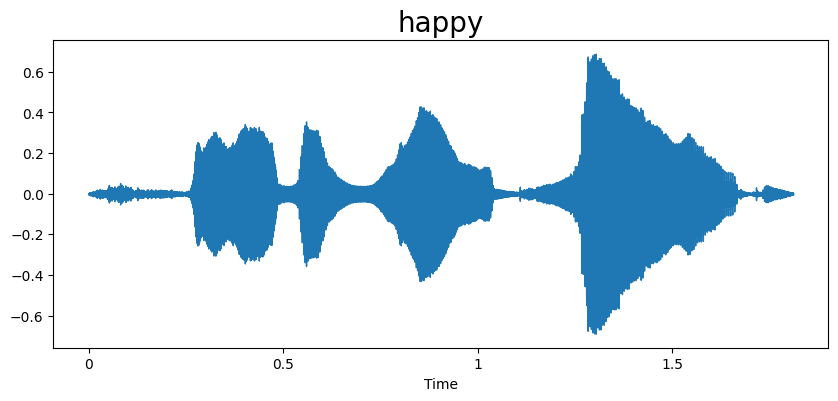

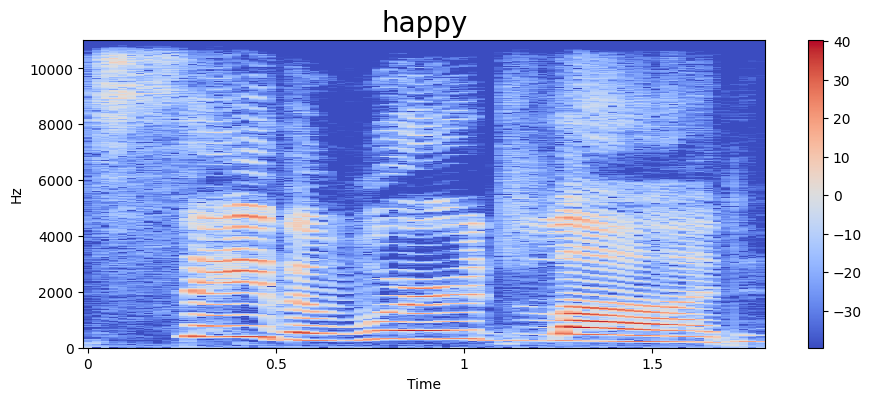

In [16]:
for x in sp_df['emotion'].drop_duplicates():
    for y in range(0 , 7): 
        emotion = x
        path = np.array(sp_df['speech'][sp_df['emotion']==emotion])[y]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)
    Audio(path)

# Feature Extraction

In [17]:
def extract_mfcc(file):
    y , sr = librosa.load(file , duration= 3 , offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y , sr = sr , n_mfcc = 40).T , axis = 0)
    return mfcc

In [18]:
extract_mfcc(sp_df['speech'][0])

array([-285.73727   ,   85.78295   ,   -2.1689112 ,   22.125532  ,
        -14.757395  ,   11.051346  ,   12.412449  ,   -3.0002618 ,
          1.0844991 ,   11.078272  ,  -17.41966   ,   -8.093213  ,
          6.5879726 ,   -4.2209535 ,   -9.15508   ,    3.52148   ,
        -13.186381  ,   14.078853  ,   19.66973   ,   22.725618  ,
         32.57464   ,   16.325035  ,   -3.8427293 ,    0.89629656,
        -11.239262  ,    6.653462  ,   -2.5883696 ,   -7.7140164 ,
        -10.941658  ,   -2.4007547 ,   -5.281288  ,    4.271157  ,
        -11.202216  ,   -9.024621  ,   -3.6669848 ,    4.869744  ,
         -1.6027985 ,    2.5600514 ,   11.454374  ,   11.233449  ],
      dtype=float32)

In [19]:
x_mfcc = sp_df['speech'].apply(lambda x : extract_mfcc(x))

In [20]:
x_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.841328, 14.658875, ...
2       [-340.11435, 53.796444, -14.267782, 20.884027,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
2795    [-374.3952, 60.864998, 0.025059083, 8.431058, ...
2796    [-313.96478, 39.847843, -5.6493053, -3.867575,...
2797    [-357.54886, 77.886055, -15.224756, 2.194633, ...
2798    [-353.1474, 101.68391, -14.175896, -12.037376,...
2799    [-389.4595, 54.042767, 1.346998, -1.4258983, -...
Name: speech, Length: 2800, dtype: object

In [21]:
X = [x for x in x_mfcc]
X = np.array(X)

In [22]:
X = np.expand_dims(X , -1)

In [23]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(sp_df[['emotion']])

In [24]:
y = y.toarray()

In [25]:
np.shape(X)

(2800, 40, 1)

# Build LSTM Model

In [26]:
from keras.models import Sequential
from keras.layers import Dense , LSTM , Dropout

In [27]:
model = Sequential([

    LSTM(256, return_sequences=False , input_shape = (40 , 1)) ,
    Dropout(0.2),
    Dense(128 , activation = 'relu'),
    Dropout(0.2),
    Dense(64 , activation='relu'),
    Dropout(0.2) , 
    Dense(7 , activation= 'softmax')]
)

In [28]:
model.compile(loss = 'categorical_crossentropy' , optimizer= 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [29]:
train = model.fit(X , y , validation_split= 0.2 , epochs = 50 , batch_size = 64)

Epoch 1/50
35/35 [==============================] - 8s 160ms/step - loss: 1.0420 - accuracy: 0.6246 - val_loss: 2.7536 - val_accuracy: 0.0286
Epoch 2/50
35/35 [==============================] - 5s 133ms/step - loss: 0.2987 - accuracy: 0.9036 - val_loss: 1.8386 - val_accuracy: 0.4143
Epoch 3/50
35/35 [==============================] - 5s 136ms/step - loss: 0.1581 - accuracy: 0.9482 - val_loss: 1.9875 - val_accuracy: 0.4875
Epoch 4/50
35/35 [==============================] - 5s 134ms/step - loss: 0.1565 - accuracy: 0.9571 - val_loss: 1.1743 - val_accuracy: 0.6679
Epoch 5/50
35/35 [==============================] - 5s 140ms/step - loss: 0.1316 - accuracy: 0.9585 - val_loss: 2.9306 - val_accuracy: 0.2714
Epoch 6/50
35/35 [==============================] - 5s 140ms/step - loss: 0.1194 - accuracy: 0.9643 - val_loss: 1.6920 - val_accuracy: 0.4946
Epoch 7/50
35/35 [==============================] - 5s 140ms/step - loss: 0.0893 - accuracy: 0.9714 - val_loss: 1.7239 - val_accuracy: 0.5518
Epoch 

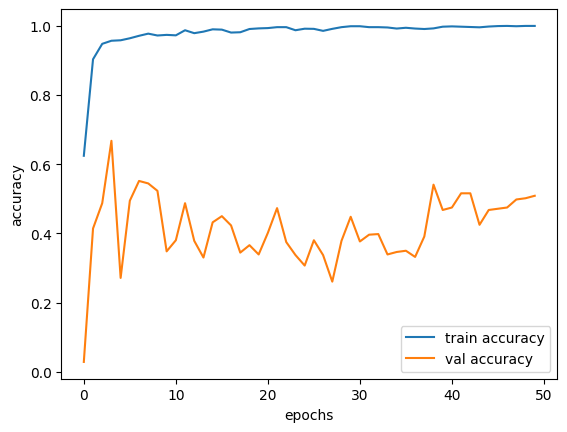

In [30]:
epoch = list(range(50))
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
plt.plot(epoch , accuracy, label = 'train accuracy')
plt.plot(epoch , val_accuracy , label = 'val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

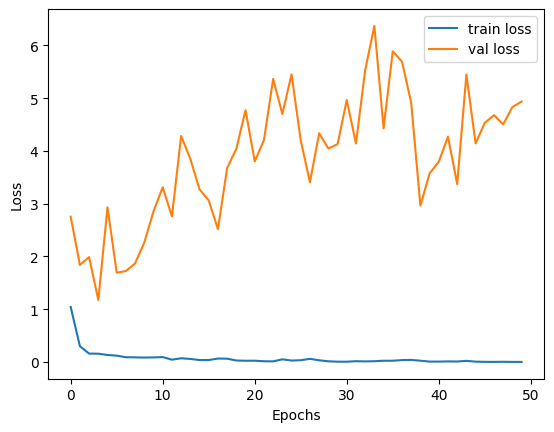

In [31]:
loss = train.history['loss']
val_loss = train.history['val_loss']
plt.plot(epoch , loss , label = 'train loss')
plt.plot(epoch , val_loss , label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()